<a href="https://colab.research.google.com/github/Vicss0529/collab-notebook/blob/main/ResNet_Layers_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#@title Resnet Visualization
https://github.com/m-peker/ResNet-Layers-Visualization/tree/master

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32
epochs = 100
data_augmentation = True

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

if K.image_data_format() == 'channels_first':
    img_rows = x_train.shape[2]
    img_cols = x_train.shape[3]
    channels = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    channels = x_train.shape[3]
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

In [8]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Start model definition.
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=7,
           padding='same',
           strides=2,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [9]:
if use_max_pool:
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    num_blocks = 3

# Building the basis of the model
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

In [10]:
# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

In [11]:
# Instantiate model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

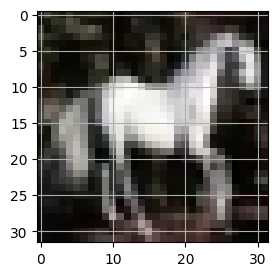

In [28]:
# Layer visualization on the test image

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img = x_test[13]

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img)
ax.grid(True)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [14]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [15]:
activations = activation_model.predict(x)

1/1 [==============================] - 1s 804ms/step


In [16]:
# first conv layer activation
first_conv_activation = activations[1]
print(first_conv_activation.shape)

(1, 16, 16, 64)


In [33]:
def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    n_row = 8
    n_column = layer_activation.shape[-1]//n_row

    f, ax = plt.subplots(n_row, n_column, figsize=(4,4))
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

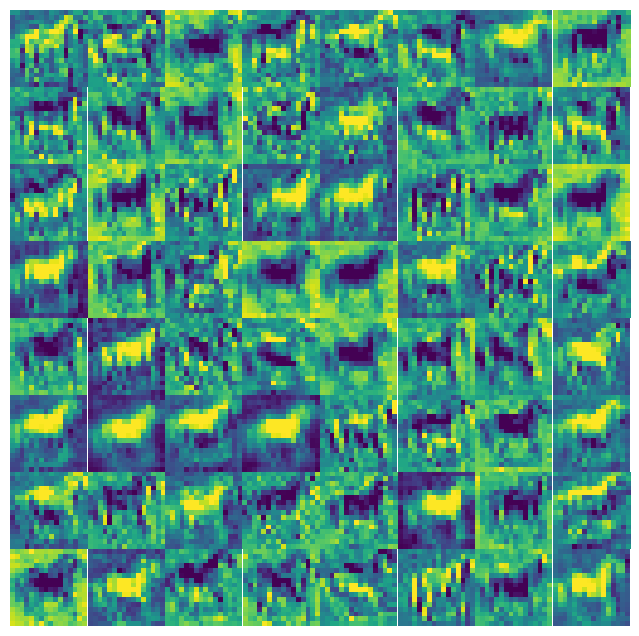

In [34]:
plot_activations(1, activations)

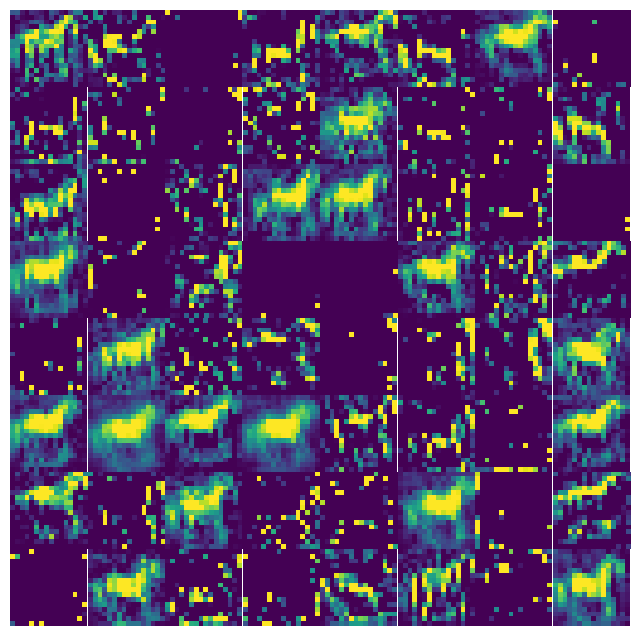

In [19]:
plot_activations(2, activations)

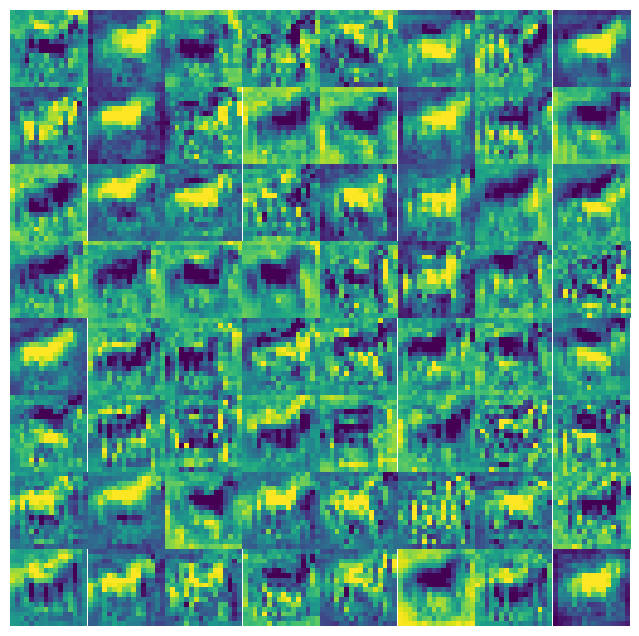

In [20]:
plot_activations(3, activations)

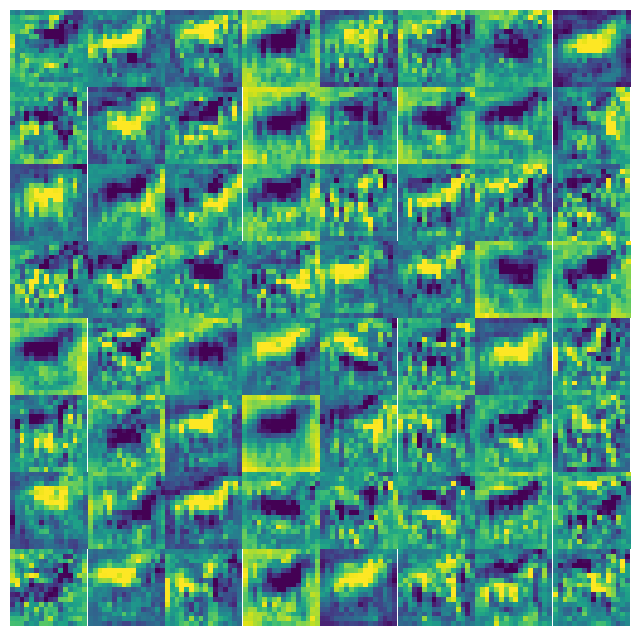

In [21]:
plot_activations(10, activations)

In [3]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [4]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });